<a href="https://colab.research.google.com/github/miphu2804/TextClassification/blob/main/textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install contractions

In [ ]:
!pip install lxml

In [ ]:
import contractions

In [ ]:
data = pd.read_csv('/content/IMDB-Dataset (1).csv')
data.head()
print(len(data))
data = data.drop_duplicates()

50000


In [ ]:
#Số samples bị trùng
numberOfDupSamples = len(data) - len(data.drop_duplicates())
print(numberOfDupSamples)

418


In [ ]:
stop = set(stopwords.words('english'))
def expandContractions(text):
  return contractions.fix(text)
def preprocessText(text):
  w1 = WordNetLemmatizer()
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text = expandContractions(text)
  emoji_clean = re.compile("[\\U0001F600-\\U0001F64F\\U0001F300-\\U0001F5FF\\U0001F680-\\U0001F6FF\\U0001F1E0-\\U0001F1FF\\U00002702-\\U000027B0\\U000024C2\\U0001F251]+",flags=re.UNICODE)
  text = emoji_clean.sub(r'', text)
  text = re.sub(r'\.(?=\S)', '.', text)
  text = re.sub(r'http\S+', '', text)
  text = ''.join([word.lower() for word in text if word not in string.punctuation])
  text = contractions.fix(text)
  # Lemmatize
  stop = set(stopwords.words('english'))
  wl = WordNetLemmatizer()
  text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()])
  return text

In [ ]:
data['review'] = data['review'].apply(preprocessText)

<ipython-input-43-fd1d6681b1b9>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


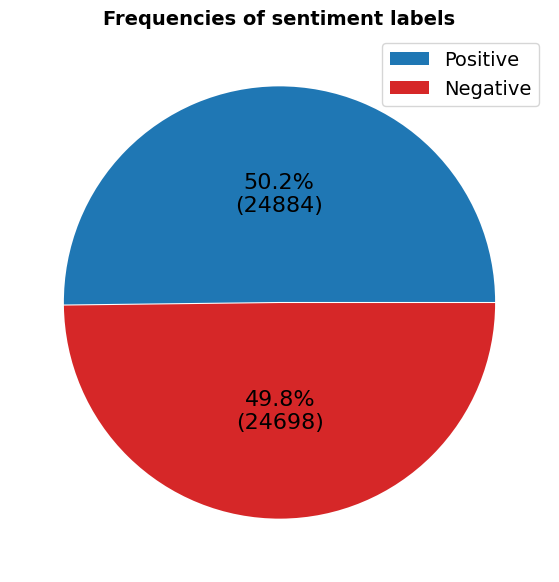

In [ ]:
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Calculate frequencies
freq_pos = len(data[data['sentiment'] == 'positive'])
freq_neg = len(data[data['sentiment'] == 'negative'])

# Create data and labels
data = [freq_pos, freq_neg]
labels = ['positive', 'negative']

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2,
        pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})

# Add title and legend
plt.title('Frequencies of sentiment labels', fontsize=14, fontweight='bold')
labels = [r'Positive', r'Negative']
plt.legend(labels, loc="best", prop={'size': 14})

# Save and show the plot
pie.savefig("PieChart.png")
plt.show()

In [ ]:
# Create a copy of the DataFrame
data_temp = data.copy()

# Calculate the number of words in each review
data_temp['words_length'] = data['review'].str.split().map(len)

# Create separate histograms for positive and negative reviews
hist_positive = sns.displot(
    data=data_temp[data_temp['sentiment'] == 'positive'],
    x='words_length',
    hue='sentiment',
    kde=True,
    height=7,
    aspect=1.1,
    legend=False,
    palette=['green']  # Set color to green for consistency
)
hist_positive.set(title='Words in Positive Reviews')

hist_negative = sns.displot(
    data=data_temp[data_temp['sentiment'] == 'negative'],
    x='words_length',
    hue='sentiment',
    kde=True,
    height=7,
    aspect=1.1,
    legend=False,
    palette=['red']
)
hist_negative.set(title='Words in Negative Reviews')

# Combine both distributions into a single plot
plt.figure(figsize=(7, 7.1))
sns.kdeplot(
    data=data_temp,
    x='words_length',
    hue='sentiment',
    fill=True,
    palette=['green', 'red']  # Use consistent colors
)
plt.title('Words in Reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(data['sentiment'])
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)
x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)